In [2]:
# --- Inport packages ---
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import math

from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
import seaborn as sns

Delta Plot Year 2050

In [16]:
# --- Read dtaa files ----
# Read 2050 capacity da
report = pd.read_excel('delta_cap_all_fc.xlsx')
graph_data = pd.DataFrame(pd.pivot_table(data = report.loc[report.year == 2050], columns = 'tech', index = 'scenario', values = 'Capacity (GW)', aggfunc = 'sum', fill_value = 0))
x_scens = report['scenario'].unique()
graph_data = graph_data.reindex(index=x_scens)
graph_data.reset_index(inplace=True)

# Get tech colors and store into a dictionary
tech_styles = pd.read_csv('tech_styles.csv')
tech_styles_dict = tech_styles.set_index(tech_styles.order)['color'].to_dict()

# Create dataframe for net change
net_change = pd.DataFrame(pd.pivot_table(data=report, columns='scenario', values='Net Level Capacity (GW)'))
net_change = pd.pivot_table(data=net_change, columns='Net Level Capacity (GW)')
net_change = net_change.reindex(index=x_scens)
net_change.reset_index(inplace=True)
net_change

,scenario,Net Level Capacity (GW)
0,BAU (FC),-99.442510
1,Low RE Costs (FC),52.248585
2,High RE Costs (FC),-59.803623
3,Reduced RE (FC),-31.656834
4,No CCS (FC),152.871756
5,Low FC Costs (FC),-0.385117
6,High FC Costs (FC),-0.672588
7,High Electrification (FC),243.718314


In [17]:
# ---- Data Organization -----
graph_data['Nuclear'] = graph_data['nuclear'] + graph_data['nuclear-smr']
graph_data['Coal'] = graph_data['coal'] + graph_data['coal-ccs_mod_upgrade']
graph_data['Gas-CC'] = graph_data['gas-cc']
graph_data['Gas-CC CCS'] = graph_data['gas-cc-ccs_mod']+graph_data['gas-cc-ccs_mod_upgrade']
graph_data['Gas-CT'] = graph_data['gas-ct']
graph_data['Oil/Gas'] = graph_data['o-g-s']
graph_data['Other RE'] = graph_data['hydro'] + graph_data['geothermal'] + graph_data['biopower'] + graph_data['lfill-gas']
graph_data['Fuel Cell'] = graph_data['fuel-cell']
graph_data['H2-CT'] = graph_data['h2-ct'] + graph_data['h2-ct_upgrade']
graph_data['Onshore Wind'] = graph_data['wind-ons']
graph_data['Offshore Wind'] = graph_data['wind-ofs']
graph_data['Solar'] = graph_data['csp'] + graph_data['upv'] + graph_data['distpv']
graph_data['Storage'] = graph_data['battery_4'] + graph_data['battery_8'] + graph_data['pumped-hydro'] #+graph_data['Canada']
#graph_data['SMR'] = graph_data['smr'] + graph_data['smr-ccs']
#graph_data['Electrolyzer'] = graph_data['electrolyzer']

graph_data=graph_data.drop(columns=['nuclear','nuclear-smr', 
                                    'coal','coal-ccs_mod_upgrade',
                                    'gas-cc','gas-cc-ccs_mod','gas-cc-ccs_mod_upgrade',
                                    'gas-ct', 'o-g-s', 'beccs_mod',
                                    'lfill-gas',
                                    'fuel-cell',
                                    'h2-ct','h2-ct_upgrade',
                                    'wind-ons', 'wind-ofs',
                                    'csp','upv','distpv',
                                    'smr', 'smr-ccs',
                                    'electrolyzer',
                                    'hydro','geothermal','biopower',
                                    'battery_4','battery_8','pumped-hydro','Canada'])
graph_data

tech,scenario,Nuclear,Coal,Gas-CC,Gas-CC CCS,Gas-CT,Oil/Gas,Other RE,Fuel Cell,H2-CT,Onshore Wind,Offshore Wind,Solar,Storage
0,BAU (FC),-19.846073,55.454920,112.945328,-50.346516,90.983863,7.813263,-1.634545,-46.414406,-9.404493,-130.038276,-2.839611,-180.893970,-61.880108
1,Low RE Costs (FC),-20.777201,-6.666200,-1.536848,-20.085409,10.648592,-0.532623,7.352151,-20.610267,-9.969223,-23.969729,-1.661258,128.766882,65.924564
2,High RE Costs (FC),14.955113,12.587306,4.693867,11.597342,-15.187856,-0.810641,0.075768,37.946186,23.544826,86.901727,-6.317910,-162.239942,-122.431324
3,Reduced RE (FC),10.437117,19.361096,-12.554558,9.033681,-14.803754,-1.676312,-5.081134,14.561686,-2.801282,-128.758639,-6.246102,47.817125,27.984999
4,No CCS (FC),7.968042,-6.822400,-228.433858,-56.289728,-25.645860,-4.599075,0.541001,156.784317,62.256661,106.206487,2.700198,240.223632,65.503208
5,Low FC Costs (FC),1.159867,0.293364,-1.583508,-4.190943,1.341549,-0.468418,-0.326420,20.933585,-2.645761,8.403212,0.237363,-9.279509,-16.302148
6,High FC Costs (FC),0.005065,-0.403801,1.079572,5.242429,-0.333905,0.050539,-0.184330,-34.614593,6.391087,-9.090194,0.363083,12.273132,21.966478
7,High Electrification (FC),7.972841,-4.185416,0.565319,16.588640,-13.415519,-2.069065,0.512933,155.296676,6.180863,411.009297,17.707576,65.639827,-33.837220


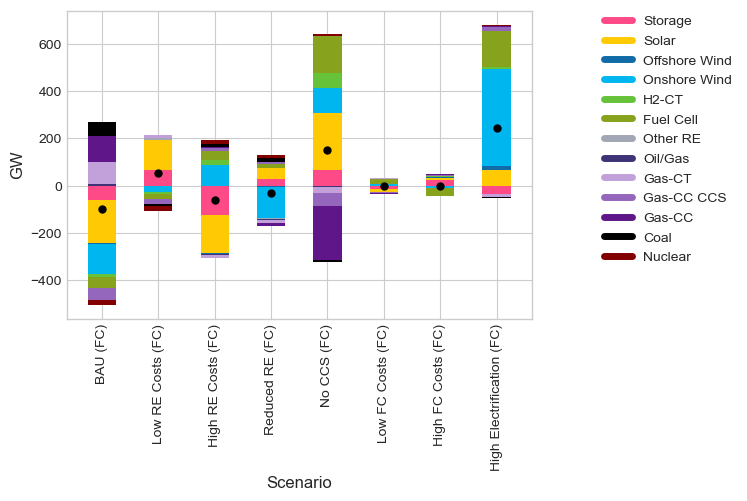

In [18]:
# ---- Plot 2050 delta installed capacity ----
# Get tech list
y_categories = graph_data.columns.tolist()
y_categories.remove('scenario')
y_categories.reverse()

# Initiate plotting
plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(1,1, figsize = (6,4),  sharex = True ) # , layout = 'constrained'

# Create lists to track stacking positions
running_sums_pos = [0]*len(x_scens)
running_sums_neg = [0]*len(x_scens)

# Loop through each tech
for tech in y_categories:
    yvals = graph_data[tech].tolist()
    # Drop tech with negligible values
    if abs(sum(yvals)) < 1:
        y_categories.remove(tech)
    bottoms = []
    # Update stacking positions
    for i in range(len(yvals)):
        if yvals[i] >=0:
            bottoms.append(running_sums_pos[i])
            running_sums_pos[i]+=yvals[i]
        else:
            bottoms.append(running_sums_neg[i])
            running_sums_neg[i]+=yvals[i]
    # Plot the bars of teh current tech for each scenario
    axs.bar(x_scens,yvals, width = 0.5, bottom = bottoms, color = tech_styles.loc[tech_styles.order==tech]['color'])

# Customize plot
axs.set_ylabel('GW', fontsize=12)
axs.set_xlabel('Scenario', fontsize=12)
plt.xticks(axs.get_xticks(), axs.get_xticklabels(), rotation=90)

# PLot dots for net change at each senario
axs.scatter(x_scens, net_change['Net Level Capacity (GW)'], c='black', marker='o',s=25, label='Net Change Value')

custom_lines = [Line2D([0], [0], color=tech_styles_dict[x], lw=5) for x in y_categories]
fig.legend(custom_lines, y_categories ,loc='upper left', bbox_to_anchor=(1,0.9), fontsize = 10)

Capacity Comparison for One Pair (build out by year)

In [92]:
# ---- Read capasity difference data ----
# read data into a dataframe
report = pd.read_excel('cap_decarb_vs_bau_fc.xlsx')
graph_data = pd.DataFrame(pd.pivot_table(data = report.loc[report.year >= 2025], columns = 'tech', index = 'year', values = 'Capacity (GW)', aggfunc = 'sum', fill_value = 0))

# Get tech colors and store into a dictionary
tech_styles = pd.read_csv('cap_tech_style.csv')
tech_styles_dict = tech_styles.set_index(tech_styles.order)['color'].to_dict()

# scenario list for x-axis labels
x_scens = report.loc[report.year >= 2025]['year'].unique()

# Create data frame for net change
net_change = pd.DataFrame(pd.pivot_table(data=report.loc[report.year >= 2025], columns='year', values='Net Level Capacity (GW)'))
net_change = pd.pivot_table(data=net_change, columns='Net Level Capacity (GW)')
net_change = net_change.reindex(index=x_scens)
net_change.reset_index(inplace=True)
net_change

,year,Net Level Capacity (GW)
0,2026,0.442317
1,2029,9.513102
2,2032,134.223728
3,2035,271.943619
4,2038,259.091632
5,2041,135.288428
6,2044,69.038595
7,2047,125.509513
8,2050,287.701701


In [93]:
# ---- Data Organization -----
graph_data['Nuclear'] = graph_data['nuclear'] + graph_data['nuclear-smr']
graph_data['Coal'] = graph_data['coal'] + graph_data['coal-ccs_mod_upgrade']
graph_data['Gas-CC'] = graph_data['gas-cc']
graph_data['Gas-CC CCS'] = graph_data['gas-cc-ccs_mod'] +graph_data['gas-cc-ccs_mod_upgrade']
graph_data['Gas-CT'] = graph_data['gas-ct']
graph_data['Oil/Gas'] = graph_data['o-g-s']
graph_data['Other RE'] = graph_data['hydro'] + graph_data['geothermal'] + graph_data['biopower'] + graph_data['lfill-gas']
graph_data['Fuel Cell'] = graph_data['fuel-cell']
graph_data['H2-CT'] = graph_data['h2-ct_upgrade']
graph_data['Onshore Wind'] = graph_data['wind-ons']
graph_data['Offshore Wind'] = graph_data['wind-ofs']
graph_data['Solar'] = graph_data['csp'] + graph_data['upv'] + graph_data['distpv']
graph_data['Storage'] = graph_data['battery_4'] + graph_data['battery_8'] + graph_data['pumped-hydro'] 
#graph_data['Electrolyzer'] = graph_data['electrolyzer']
#graph_data['SMR'] = graph_data['smr'] + graph_data['smr-ccs']

graph_data=graph_data.drop(columns=['nuclear','nuclear-smr', 
                                    'coal','coal-ccs_mod_upgrade',
                                    'gas-cc','gas-cc-ccs_mod','gas-cc-ccs_mod_upgrade',
                                    'gas-ct', 'o-g-s', 'beccs_mod',
                                    'lfill-gas',
                                    'fuel-cell',
                                    'h2-ct_upgrade',
                                    'wind-ons', 'wind-ofs',
                                    'csp','upv','distpv',
                                    'hydro','geothermal','biopower',
                                    'electrolyzer', 'smr', 'smr-ccs',
                                    'battery_4','battery_8','pumped-hydro','Canada'])
graph_data

tech,Nuclear,Coal,Gas-CC,Gas-CC CCS,Gas-CT,Oil/Gas,Other RE,Fuel Cell,H2-CT,Onshore Wind,Offshore Wind,Solar,Storage
year,,,,,,,,,,,,,
2026,0.000000,-0.116849,-2.510632,0.000000,-7.524632,-0.026948,0.000000,9.739242,0.000000,0.176787,0.000000e+00,0.502950,0.171757
2029,0.000000,-0.401664,-11.572054,0.000000,-11.873166,-0.026948,0.043286,15.929122,0.000000,4.001423,0.000000e+00,6.668630,6.693017
2032,0.000000,-29.695148,-12.897710,3.497812,-11.929189,-0.254466,0.850915,1.605352,0.000000,79.955528,9.999965e-10,85.830193,17.239191
2035,15.883400,-104.535539,-20.316388,7.445916,-75.617671,-28.392888,0.397232,18.161205,7.868830,133.260878,0.000000e+00,210.489966,84.059328
2038,14.658465,-99.466729,-24.379631,8.403567,-78.734324,-25.482235,0.402971,30.421116,7.946786,118.493980,1.791095e+00,188.424357,89.576292
2041,20.540901,-95.375383,-27.167111,18.302259,-78.994678,-22.592894,0.387284,64.246398,7.908395,65.089206,1.035845e+01,84.262013,51.678384
2044,20.540901,-87.444092,-27.758935,26.793867,-82.809861,-20.409378,1.575234,80.205452,10.018865,58.990344,1.546999e+01,7.746252,19.850167
2047,20.540901,-71.303561,-53.717616,43.346769,-80.434108,-14.892311,1.601162,66.852728,8.010392,73.261851,1.181638e+01,47.140992,22.918919
2050,19.846073,-55.454920,-112.945328,50.346516,-90.983863,-7.813263,1.634545,46.414406,9.404493,130.038276,2.839611e+00,180.893970,61.880108


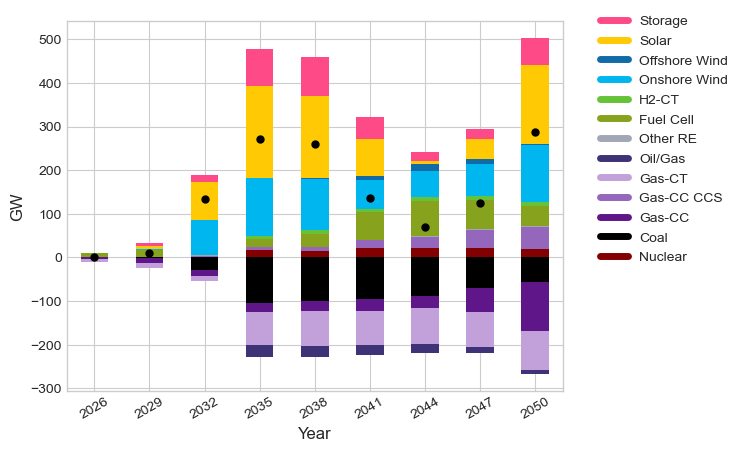

In [94]:
# Get tech list
y_categories = graph_data.columns.to_list()
y_categories.reverse()

# plot styles
plt.style.use('seaborn-v0_8-whitegrid')

# Plot stacked bar
fig = graph_data.plot.bar(stacked=True, color = tech_styles_dict)

# Plot dots to indicate net change at each year
fig.scatter(net_change.index.to_list(), net_change['Net Level Capacity (GW)'], c='black', marker='o',s=25, label='Net Change Value')

# Customize plot
fig.set_ylabel('GW', fontsize = 12)
fig.set_xlabel('Year', fontsize = 12)
plt.xticks(rotation=30)

# Customize legend
custom_lines = [Line2D([0], [0], color=tech_styles_dict[x], lw=5) for x in y_categories]
fig.legend(custom_lines, y_categories ,loc='upper left', bbox_to_anchor=(1.050,1.05), fontsize = 10)

Delta Plot for H2 Production Capacity (SMR & electrolyzer)

In [3]:
# ---Read 2050 capacity data ----
# read data into dataframe
report = pd.read_excel('cap_all_smr&electrolyzer.xlsx', sheet_name='del_cap_all (FC vs noFC)')
graph_data = pd.DataFrame(pd.pivot_table(data = report.loc[report.year == 2050], columns = 'tech', index = 'scenario', values = ['Capacity (GW)','ele_efficiency (kWh/kg)'], aggfunc = 'sum', fill_value = 0))
x_scens = report['scenario'].unique() # Get x-axis labels
graph_data = graph_data.reindex(index=x_scens)
graph_data.reset_index(inplace=True)

# Get tech colors and store into a dictionary
tech_styles = pd.read_csv('cap_tech_style.csv')
tech_styles_dict = tech_styles.set_index(tech_styles.order)['color'].to_dict()
graph_data

scenario Capacity (GW)                 \
tech                             Electrolyzer  SMR   SMR-CCS   
0                   Decarb (FC)     -2.069985  0.0  0.490486   
1             Low RE Costs (FC)      7.735406  0.0  0.355050   
2            High RE Costs (FC)     -7.489699  0.0  0.526473   
3               Reduced RE (FC)     -7.255310  0.0  0.511718   
4                   No CCS (FC)    -11.590595  0.0  0.000000   
5             Low FC Costs (FC)     -0.619249  0.0  0.585075   
6            High FC Costs (FC)     -4.648221  0.0  0.342822   
7     High Electrification (FC)    -23.811011  0.0  0.728081   

     ele_efficiency (kWh/kg)                 
tech            Electrolyzer    SMR SMR-CCS  
0                        1.9  51.45    0.88  
1                        1.9  51.45    0.88  
2                        1.9  51.45    0.88  
3                        1.9  51.45    0.88  
4                        1.9  51.45    0.88  
5                        1.9  51.45    0.88  
6                        1.9  51.45    0.88  
7                        1.9  51.45    0.88

In [31]:
# Calculating H2 procution capacity using efficiency fo reach tech
for tech in graph_data['Capacity (GW)'].columns.to_list():
    graph_data['Capacity (metric tons/day)', tech] = graph_data['Capacity (GW)', tech]/graph_data['ele_efficiency (kWh/kg)', tech] *1e6 *24 /1000
    net_change['Net Level Capacity (metric tons/day)', tech] = net_change['Net Level Capacity (GW)', tech]/graph_data['ele_efficiency (kWh/kg)', tech] *1e6 *24 /1000

# Capitalize and lump
graph_data['Capacity (metric tons/day)','SMR'] = graph_data['Capacity (metric tons/day)','SMR'] + graph_data['Capacity (metric tons/day)','SMR-CCS']
graph_data.drop(('Capacity (metric tons/day)', 'SMR-CCS'), axis=1, inplace=True)
graph_data

scenario Capacity (GW)                 \
tech                             Electrolyzer  SMR   SMR-CCS   
0                   Decarb (FC)     -2.069985  0.0  0.490486   
1             Low RE Costs (FC)      7.735406  0.0  0.355050   
2            High RE Costs (FC)     -7.489699  0.0  0.526473   
3               Reduced RE (FC)     -7.255310  0.0  0.511718   
4                   No CCS (FC)    -11.590595  0.0  0.000000   
5             Low FC Costs (FC)     -0.619249  0.0  0.585075   
6            High FC Costs (FC)     -4.648221  0.0  0.342822   
7     High Electrification (FC)    -23.811011  0.0  0.728081   

     ele_efficiency (kWh/kg)                Capacity (metric tons/day)  \
tech            Electrolyzer    SMR SMR-CCS               Electrolyzer   
0                        1.9  51.45    0.88              -26147.178404   
1                        1.9  51.45    0.88               97710.393461   
2                        1.9  51.45    0.88              -94606.723339   
3                        1.9  51.45    0.88              -91646.022240   
4                        1.9  51.45    0.88             -146407.519680   
5                        1.9  51.45    0.88               -7822.091027   
6                        1.9  51.45    0.88              -58714.365095   
7                        1.9  51.45    0.88             -300770.663192   

                    
tech           SMR  
0     13376.883736  
1      9683.181300  
2     14358.359209  
3     13955.939864  
4         0.000000  
5     15956.590091  
6      9349.681445  
7     19856.765727

In [34]:
# Create dataframe for net changes
net_change=graph_data['Capacity (metric tons/day)'].set_index(graph_data.scenario)
net_change['Net Level Capacity (metric tons/day)'] = net_change.sum(axis=1)

net_change

tech,Electrolyzer,SMR,Net Level Capacity (metric tons/day)
scenario,,,
Decarb (FC),-26147.178404,13376.883736,-12770.294668
Low RE Costs (FC),97710.393461,9683.181300,107393.574761
High RE Costs (FC),-94606.723339,14358.359209,-80248.364130
Reduced RE (FC),-91646.022240,13955.939864,-77690.082376
No CCS (FC),-146407.519680,0.000000,-146407.519680
Low FC Costs (FC),-7822.091027,15956.590091,8134.499064
High FC Costs (FC),-58714.365095,9349.681445,-49364.683649
High Electrification (FC),-300770.663192,19856.765727,-280913.897464


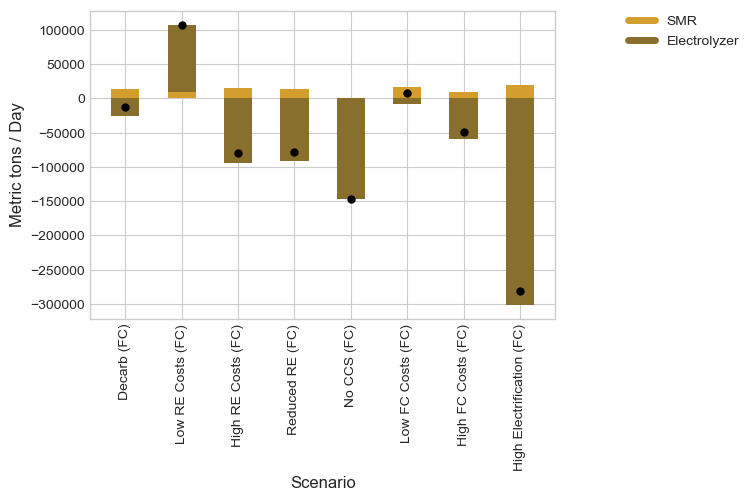

In [44]:
# ---- Plot 2050 delta installed capacity ----

# Get tech list
y_categories = graph_data['Capacity (metric tons/day)'].columns.to_list()
y_categories.reverse()

# plot initiation
plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(1,1, figsize = (6,4),  sharex = True ) # , layout = 'constrained'

# Create lists to track stacking positions
running_sums_pos = [0]*len(x_scens)
running_sums_neg = [0]*len(x_scens)

# Loop through all tecshs
for tech in y_categories:
    yvals = graph_data['Capacity (metric tons/day)'][tech].tolist()
    # Drop techs with negligible values
    if abs(sum(yvals)) < 1:
        y_categories.remove(tech)
    bottoms = []
    # Update stacking posiitons
    for i in range(len(yvals)):
        if yvals[i] >= 0:
            bottoms.append(running_sums_pos[i])
            running_sums_pos[i]+=yvals[i]
        else:
            bottoms.append(running_sums_neg[i])
            running_sums_neg[i]+=yvals[i]
    # Plot bars of the current tech at each scenario
    axs.bar(x_scens,yvals, width = 0.5, bottom = bottoms, color = tech_styles.loc[tech_styles.order==tech]['color'])

# Customize plot
axs.set_ylabel('Metric tons / Day', fontsize=12)
axs.set_xlabel('Scenario', fontsize=12)
plt.ticklabel_format(axis='y',style='sci')
plt.xticks(axs.get_xticks(), axs.get_xticklabels(), rotation=90)

# Plot net change as a dot for each scenario
axs.scatter(x_scens, net_change['Net Level Capacity (metric tons/day)'], c='black', marker='o',s=25, label='Net Change Value')

# Customize legend
custom_lines = [Line2D([0], [0], color=tech_styles_dict[x], lw=5) for x in y_categories]
fig.legend(custom_lines, y_categories ,loc='upper left', bbox_to_anchor=(1,0.9), fontsize = 10)
